In [1]:
import sys
from tqdm import tqdm
from typing import List, Dict, Tuple

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pathlib import Path
import math
import json
import re
def load_jsonl(path: Path):
    """
    Load cleaned json file for testing
    path: path to the file containing the data for processing
    """
    if not path.exists():
        return []
    with open(path, "r") as fid:
        # no sanity check because the data was already cleaned
        data = [json.loads(l) for l in fid]
    return data

# Specific to `mlx` framework

The code here is specific to my machine which is based on MacOS.

Here, I use `mlx` framework to train LLM. Your case is different but the pattern and process should be similar.

In [4]:
from mlx_lm import load, generate
from mlx_lm.sample_utils import make_sampler

/Users/cto/Library/Caches/pypoetry/virtualenvs/chatwithfasthtml-43dZcm8R-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load finetuned LLM

In [5]:
# load finetuned LLM and its tokenizer
model, tokenizer = load("mlx-community/gemma-3-1b-it-8bit", adapter_path="./robot-command-retrieval/adapters-gemma-3-1b-it-8bit/")
# model, tokenizer = load("mlx-community/gemma-2-2b-it-4bit", adapter_path="./robot-command-retrieval/adapters-gemma-2-2b-it-4bit/")

Fetching 9 files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 73156.47it/s]


In [6]:
# this is specific to mlx framework
# here I need to explicitly add eos token to allow mlx to stop generate tokens after encountering eos token
tokenizer.add_eos_token("<end_of_turn>")

In [7]:
#### Configuration for LLM to generate answer
temperature = 1.5 # 0.0 # the randomness of LLM answer, the smaller, the more deterministic the answer is. the bigger, the more random the answer is
top_p = 1.0
min_p = 0.1 # 0.0
min_tokens_to_keep = 1

In [8]:
# this is specific to mlx framework
sampler = make_sampler(temperature, top_p, min_p, min_tokens_to_keep)

In [9]:
# test the finetuned LLM
# in my finetuning, I add additional prompt "Respond strictly in a JSON array format for a Khmer robot assistant".
# So, when deploying, I need to add this additional prompt to the user command.
add_prompt = "Respond strictly in a JSON array format for a Khmer robot assistant."
prompt = f"{add_prompt} ទៅមុខមួយម៉ែត្រ"
print(prompt)
#prompt = "ទៅមុខមួយម៉ែត្រ"
messages = [
    {"role": "user", "content": prompt}
]
prompt = tokenizer.apply_chat_template(
    messages, add_generation_prompt=True
)

generate(model, tokenizer, prompt=prompt, verbose=False, sampler=sampler)

Respond strictly in a JSON array format for a Khmer robot assistant. ទៅមុខមួយម៉ែត្រ


"{'action': 'move', 'params': {'unit': 1, 'is_forward': True, 'scale': 'meter', 'result': 'unit'}}"

## Load Data

In [10]:
data = load_jsonl(Path("./robot-command-retrieval/data/valid.jsonl"))

We can check the data by printing a few elements.

In [11]:
data[3]

{'messages': [{'role': 'user',
   'content': 'Respond strictly in a JSON array format for a robot assistant. រ៉ូបូតទៅមុខ ១២.៦៥ ម៉ែត្រ ដោយល្បឿន ៥.៨៥ ម៉ែត្រ/វិ'},
  {'role': 'assistant',
   'content': "{'action': 'move', 'params': {'speed': 5.85, 'unit': 12.65, 'is_forward': True, 'scale': 'meter'}}"}]}

Each element of `data` is a dictionary with a single key `messages`. Its value is a `list` of dictionaries containing user's prompt and the expected answer from the LLM.

In [12]:
data[3]['messages']

[{'role': 'user',
  'content': 'Respond strictly in a JSON array format for a robot assistant. រ៉ូបូតទៅមុខ ១២.៦៥ ម៉ែត្រ ដោយល្បឿន ៥.៨៥ ម៉ែត្រ/វិ'},
 {'role': 'assistant',
  'content': "{'action': 'move', 'params': {'speed': 5.85, 'unit': 12.65, 'is_forward': True, 'scale': 'meter'}}"}]

## Post process the prediction of LLM

From now on, we will call `prediction` the output from LLM and `label` the answer expected from LLM.

In [13]:
def validate_and_get_polar_coord(pred_cmd: str, label_cmd: str):
    """
    We first validate the correctness of form of LLM's prediction.
    After that, we deduce the polar coordinates corresponding to the prediction.

    In case that the prediction is not valid, we return [0.0, 0.0] to say
    that the robot does not move.
    """
    try:
        dict_pred_cmd = eval(pred_cmd)
        assert isinstance(dict_pred_cmd, dict)
        assert 'action' in dict_pred_cmd
        assert 'params' in dict_pred_cmd
        for k in eval(label_cmd)['params']:
            assert k in dict_pred_cmd['params']
        return get_distance_and_angle(dict_pred_cmd)
    except:
        print("Unexpected error:", sys.exc_info()[0])
        return [0.0, 0.0]

In [14]:
def get_distance_and_angle(cmd: dict):
    """
    Given the correct JSON format, deduce the corresponding polar coordinates
    """
    polar_coord = [0.0, 0.0]
    unit = float(cmd['params'].get('unit', 0.0))
    scale = cmd['params'].get('scale', '')
    duration = cmd['params'].get('duration', 0)
    if cmd['action'] == 'move':
        if scale == 'centimeter':
            # convert to meter
            unit /= 100.0
        direction = cmd['params'].get('is_forward', True)
        if direction: polar_coord[0] += unit
        else: polar_coord[0] -= unit
    elif cmd['action'] == 'rotate':
        if scale == 'degree' or scale == '':
            # convert degree to radian
            unit = math.radians(unit)
        direction = cmd['params'].get('is_clockwise', True)
        if direction: polar_coord[1] += unit
        else: polar_coord[1] -= unit
    return polar_coord

In [15]:
def update_robot_pose(x, y, t, polar_coord):
    """
    In 2D movement, the pose of robot is characterised by its position (x,y) and orientation (t)
    In our setup, either radius (first component) or orientation (second component) is not null.
    In case, both radius and orientation are not null, we encounter an error.
    """
    if polar_coord[0] != 0.0 and polar_coord[1] == 0.0:
        x += polar_coord[0]*math.cos(t)
        y += polar_coord[0]*math.sin(t)
        return x, y, t
    elif polar_coord[0] == 0.0 and polar_coord[1] != 0.0:
        t += polar_coord[1]
        return x, y, t
    elif polar_coord[0] != 0.0 and polar_coord[1] != 0.0:
        print("error", polar_coord)
        return x, y, t
    else:
        return x, y, t

In [16]:
def riemanian_distance(x_pred, y_pred, t_pred, x_label, y_label, t_label):
    """
    Formula to compute the distance between 2 robot's poses in 2D movement
    """
    alpha = 1.0 # calibrate the importance between translation and rotation
    d = math.sqrt((x_pred - x_label)**2 + (y_pred - y_label)**2 + alpha * ((t_pred - t_label)**2))
    return d

In [17]:
def update_polar_coord(to_update, for_update):
    return [to_update[0] + for_update[0], to_update[1] + for_update[1]]

In [18]:
x_start, y_start, t_start = 0.0, 0.0, 0.0

k = 10 # the number of times LLM can answer

pred_r, pred_t, rd = [], [], []
label_r, label_t = [], []
predictions = []
references = []
for i in tqdm(range(len(data))):
    # we split string by `\n` to cover multiple action case
    label_list_str_dict: List[str] = data[i]['messages'][1]['content'].split('\n')
    
    prompt = tokenizer.apply_chat_template(
        [data[i]['messages'][0]], add_generation_prompt=True
    )
    votes: Dict[str, int] = {}
    dict_pairs: Dict[str, List[str]] = {}
    for _ in range(k):
        pred = generate(model, tokenizer, prompt=prompt, verbose=False, sampler=sampler)
        pred_list_str_dict = pred.split('\n')
        key = ""
        for pred_str_d, lab_str_d in zip(pred_list_str_dict, label_list_str_dict):
            pred_coord = validate_and_get_polar_coord(pred_str_d, lab_str_d)
            key += str(pred_coord)
        try:
            votes[key] += 1
        except KeyError:
            votes[key] = 1
            dict_pairs[key] = list(pred_list_str_dict)
    
    voted_pred_list_str_dict = []
    nb_vote = 0
    for key, vote in votes.items():
        if vote >= nb_vote:
            voted_pred_list_str_dict = list(dict_pairs[key])
            nb_vote = vote
        
    pred_coord = [0.0, 0.0]
    label_coord = [0.0, 0.0]

    x_pred, y_pred, t_pred = x_start, y_start, t_start
    x_label, y_label, t_label = x_start, y_start, t_start
    for pred_str_d, lab_str_d in zip(voted_pred_list_str_dict, label_list_str_dict):
        # print(pred_str_d)
        predictions.append(pred_str_d)
        tmp_pred_coord = validate_and_get_polar_coord(pred_str_d, lab_str_d)
        x_pred, y_pred, t_pred = update_robot_pose(x_pred, y_pred, t_pred, tmp_pred_coord)
        pred_coord = update_polar_coord(pred_coord, tmp_pred_coord)

        references.append(lab_str_d)
        tmp_label_coord = get_distance_and_angle(eval(lab_str_d))
        x_label, y_label, t_label = update_robot_pose(x_label, y_label, t_label, tmp_label_coord)
        label_coord = update_polar_coord(label_coord, tmp_label_coord)

    rd.append(riemanian_distance(x_pred, y_pred, t_pred, x_label, y_label, t_label))
    pred_r.append(pred_coord[0])
    pred_t.append(pred_coord[1])
    label_r.append(label_coord[0])
    label_t.append(label_coord[1])
# print(err_r)
# print(err_t)

  1%|█▎                                                                                                                                 | 6/598 [01:09<1:49:39, 11.11s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


  1%|█▌                                                                                                                                 | 7/598 [01:19<1:47:09, 10.88s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


  2%|███                                                                                                                               | 14/598 [02:21<1:42:32, 10.53s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


  3%|███▋                                                                                                                              | 17/598 [02:56<1:45:49, 10.93s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


  5%|██████▎                                                                                                                           | 29/598 [05:34<2:18:40, 14.62s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


  5%|██████▌                                                                                                                           | 30/598 [05:41<1:56:29, 12.30s/it]

Unexpected error: <class 'AssertionError'>


  6%|████████▎                                                                                                                         | 38/598 [07:26<1:58:33, 12.70s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


  7%|█████████▎                                                                                                                        | 43/598 [08:32<1:58:15, 12.78s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 11%|██████████████▏                                                                                                                   | 65/598 [14:08<2:14:25, 15.13s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 11%|██████████████▌                                                                                                                   | 67/598 [14:22<1:36:45, 10.93s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 11%|██████████████▊                                                                                                                   | 68/598 [14:30<1:29:41, 10.15s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 12%|███████████████                                                                                                                   | 69/598 [14:38<1:23:29,  9.47s/it]

Unexpected error: <class 'ValueError'>


 12%|███████████████▏                                                                                                                  | 70/598 [14:42<1:09:27,  7.89s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 13%|█████████████████▏                                                                                                                | 79/598 [16:20<1:38:03, 11.34s/it]

Unexpected error: <class 'AssertionError'>


 14%|██████████████████▋                                                                                                               | 86/598 [17:47<1:42:20, 11.99s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 15%|███████████████████▏                                                                                                              | 88/598 [18:02<1:22:44,  9.73s/it]

Unexpected error: <class 'SyntaxError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'SyntaxError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 15%|███████████████████▎                                                                                                              | 89/598 [18:24<1:54:59, 13.56s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 16%|█████████████████████                                                                                                             | 97/598 [19:57<1:22:47,  9.92s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 16%|█████████████████████▎                                                                                                            | 98/598 [20:13<1:37:52, 11.74s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 17%|██████████████████████                                                                                                           | 102/598 [21:05<1:45:19, 12.74s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 17%|██████████████████████▏                                                                                                          | 103/598 [21:13<1:34:06, 11.41s/it]

Unexpected error: <class 'AssertionError'>


 18%|██████████████████████▋                                                                                                          | 105/598 [21:33<1:28:01, 10.71s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 18%|██████████████████████▊                                                                                                          | 106/598 [21:50<1:43:46, 12.66s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 19%|████████████████████████▏                                                                                                        | 112/598 [23:30<2:14:56, 16.66s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 19%|████████████████████████▍                                                                                                        | 113/598 [23:40<1:58:23, 14.65s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 19%|████████████████████████▌                                                                                                        | 114/598 [23:58<2:05:53, 15.61s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 19%|█████████████████████████                                                                                                        | 116/598 [24:33<2:13:33, 16.62s/it]

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


 20%|█████████████████████████▉                                                                                                       | 120/598 [25:15<1:38:56, 12.42s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 20%|██████████████████████████                                                                                                       | 121/598 [25:26<1:33:53, 11.81s/it]

Unexpected error: <class 'SyntaxError'>


 22%|████████████████████████████▎                                                                                                    | 131/598 [27:34<1:41:21, 13.02s/it]

Unexpected error: <class 'AssertionError'>


 22%|████████████████████████████▍                                                                                                    | 132/598 [27:42<1:28:36, 11.41s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 22%|████████████████████████████▋                                                                                                    | 133/598 [28:02<1:49:04, 14.07s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 27%|██████████████████████████████████▋                                                                                              | 161/598 [34:40<1:38:56, 13.58s/it]

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'SyntaxError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


 27%|██████████████████████████████████▉                                                                                              | 162/598 [34:47<1:24:04, 11.57s/it]

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


 27%|███████████████████████████████████▍                                                                                             | 164/598 [35:07<1:18:24, 10.84s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 28%|████████████████████████████████████▍                                                                                            | 169/598 [36:36<1:59:32, 16.72s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 29%|█████████████████████████████████████▎                                                                                           | 173/598 [37:41<1:52:29, 15.88s/it]

Unexpected error: <class 'AssertionError'>


 29%|█████████████████████████████████████▌                                                                                           | 174/598 [38:02<2:03:01, 17.41s/it]

Unexpected error: <class 'AssertionError'>


 31%|████████████████████████████████████████▎                                                                                        | 187/598 [41:21<1:53:10, 16.52s/it]

Unexpected error: <class 'ValueError'>


 31%|████████████████████████████████████████▌                                                                                        | 188/598 [41:26<1:29:03, 13.03s/it]

Unexpected error: <class 'ValueError'>


 32%|█████████████████████████████████████████▍                                                                                       | 192/598 [42:19<1:41:38, 15.02s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 32%|█████████████████████████████████████████▋                                                                                       | 193/598 [42:30<1:34:02, 13.93s/it]

Unexpected error: <class 'AssertionError'>


 33%|██████████████████████████████████████████▋                                                                                      | 198/598 [43:38<1:24:46, 12.72s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 34%|███████████████████████████████████████████▌                                                                                     | 202/598 [44:38<1:31:48, 13.91s/it]

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


 36%|███████████████████████████████████████████████                                                                                  | 218/598 [48:10<1:19:22, 12.53s/it]

Unexpected error: <class 'ValueError'>


 37%|███████████████████████████████████████████████▏                                                                                 | 219/598 [48:15<1:06:14, 10.49s/it]

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


 37%|████████████████████████████████████████████████▏                                                                                  | 220/598 [48:23<59:42,  9.48s/it]

Unexpected error: <class 'ValueError'>


 39%|██████████████████████████████████████████████████▍                                                                              | 234/598 [51:38<1:27:06, 14.36s/it]

Unexpected error: <class 'ValueError'>


 39%|██████████████████████████████████████████████████▉                                                                              | 236/598 [52:03<1:25:04, 14.10s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 40%|███████████████████████████████████████████████████▏                                                                             | 237/598 [52:12<1:15:28, 12.54s/it]

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


 40%|████████████████████████████████████████████████████▏                                                                            | 242/598 [53:20<1:23:28, 14.07s/it]

Unexpected error: <class 'AssertionError'>


 42%|█████████████████████████████████████████████████████▋                                                                           | 249/598 [54:58<1:26:59, 14.96s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 42%|█████████████████████████████████████████████████████▉                                                                           | 250/598 [55:14<1:28:53, 15.33s/it]

Unexpected error: <class 'AssertionError'>


 43%|███████████████████████████████████████████████████████▋                                                                         | 258/598 [57:11<1:27:34, 15.45s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 43%|███████████████████████████████████████████████████████▊                                                                         | 259/598 [57:22<1:18:59, 13.98s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 44%|████████████████████████████████████████████████████████▎                                                                        | 261/598 [57:50<1:21:50, 14.57s/it]

Unexpected error: <class 'AssertionError'>


 44%|████████████████████████████████████████████████████████▌                                                                        | 262/598 [57:59<1:11:49, 12.83s/it]

Unexpected error: <class 'AssertionError'>


 44%|████████████████████████████████████████████████████████▋                                                                        | 263/598 [58:10<1:08:52, 12.33s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 44%|████████████████████████████████████████████████████████▉                                                                        | 264/598 [58:22<1:07:30, 12.13s/it]

Unexpected error: <class 'AssertionError'>


 46%|██████████████████████████████████████████████████████████▊                                                                    | 277/598 [1:01:34<1:29:07, 16.66s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 46%|███████████████████████████████████████████████████████████                                                                    | 278/598 [1:01:43<1:16:51, 14.41s/it]

Unexpected error: <class 'AssertionError'>


 47%|███████████████████████████████████████████████████████████▋                                                                   | 281/598 [1:02:34<1:28:32, 16.76s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 48%|█████████████████████████████████████████████████████████████▌                                                                 | 290/598 [1:04:55<1:26:57, 16.94s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 49%|█████████████████████████████████████████████████████████████▊                                                                 | 291/598 [1:05:12<1:26:15, 16.86s/it]

Unexpected error: <class 'AssertionError'>


 49%|██████████████████████████████████████████████████████████████▏                                                                | 293/598 [1:05:49<1:29:58, 17.70s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 49%|██████████████████████████████████████████████████████████████▍                                                                | 294/598 [1:06:01<1:21:56, 16.17s/it]

Unexpected error: <class 'AssertionError'>


 51%|████████████████████████████████████████████████████████████████▌                                                              | 304/598 [1:08:24<1:19:23, 16.20s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 51%|████████████████████████████████████████████████████████████████▊                                                              | 305/598 [1:08:36<1:12:13, 14.79s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 51%|████████████████████████████████████████████████████████████████▉                                                              | 306/598 [1:08:44<1:03:13, 12.99s/it]

Unexpected error: <class 'AssertionError'>


 52%|██████████████████████████████████████████████████████████████████▍                                                            | 313/598 [1:10:45<1:23:35, 17.60s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 53%|██████████████████████████████████████████████████████████████████▋                                                            | 314/598 [1:10:57<1:15:24, 15.93s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 53%|███████████████████████████████████████████████████████████████████                                                            | 316/598 [1:11:26<1:13:35, 15.66s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 53%|███████████████████████████████████████████████████████████████████▎                                                           | 317/598 [1:11:37<1:07:10, 14.34s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 54%|█████████████████████████████████████████████████████████████████████                                                          | 325/598 [1:14:20<1:52:33, 24.74s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 329/598 [1:15:17<1:15:10, 16.77s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 56%|██████████████████████████████████████████████████████████████████████▋                                                        | 333/598 [1:16:04<1:02:38, 14.18s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 56%|██████████████████████████████████████████████████████████████████████▉                                                        | 334/598 [1:16:17<1:00:34, 13.77s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 56%|███████████████████████████████████████████████████████████████████████▏                                                       | 335/598 [1:16:35<1:06:06, 15.08s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 336/598 [1:16:45<59:34, 13.64s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 57%|████████████████████████████████████████████████████████████████████████▏                                                      | 340/598 [1:17:41<1:00:37, 14.10s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 57%|█████████████████████████████████████████████████████████████████████████▊                                                       | 342/598 [1:18:06<58:02, 13.60s/it]

Unexpected error: <class 'AssertionError'>


 59%|████████████████████████████████████████████████████████████████████████████▎                                                    | 354/598 [1:20:25<41:22, 10.17s/it]

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


 59%|████████████████████████████████████████████████████████████████████████████▌                                                    | 355/598 [1:20:31<36:26,  9.00s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 60%|████████████████████████████████████████████████████████████████████████████▊                                                    | 356/598 [1:20:41<37:09,  9.21s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 60%|█████████████████████████████████████████████████████████████████████████████▊                                                   | 361/598 [1:21:43<50:02, 12.67s/it]

Unexpected error: <class 'AssertionError'>


 62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 368/598 [1:23:30<1:01:25, 16.02s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 62%|███████████████████████████████████████████████████████████████████████████████▌                                                 | 369/598 [1:23:42<56:45, 14.87s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 62%|████████████████████████████████████████████████████████████████████████████████▏                                                | 372/598 [1:24:26<52:05, 13.83s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 62%|████████████████████████████████████████████████████████████████████████████████▍                                                | 373/598 [1:24:35<47:02, 12.54s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 64%|███████████████████████████████████████████████████████████████████████████████████                                              | 385/598 [1:27:15<49:56, 14.07s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 65%|███████████████████████████████████████████████████████████████████████████████████▎                                             | 386/598 [1:27:27<47:48, 13.53s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 66%|█████████████████████████████████████████████████████████████████████████████████████▋                                           | 397/598 [1:30:09<48:23, 14.44s/it]

Unexpected error: <class 'AssertionError'>


 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 399/598 [1:30:41<49:00, 14.78s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                       | 416/598 [1:34:56<50:23, 16.61s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                       | 417/598 [1:35:11<49:06, 16.28s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 70%|██████████████████████████████████████████████████████████████████████████████████████████▍                                      | 419/598 [1:35:56<57:59, 19.44s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 70%|██████████████████████████████████████████████████████████████████████████████████████████▌                                      | 420/598 [1:36:07<49:47, 16.78s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 70%|██████████████████████████████████████████████████████████████████████████████████████████▊                                      | 421/598 [1:36:16<42:56, 14.56s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 71%|███████████████████████████████████████████████████████████████████████████████████████████                                      | 422/598 [1:36:29<40:57, 13.96s/it]

Unexpected error: <class 'AssertionError'>


 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                     | 424/598 [1:36:48<34:04, 11.75s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 434/598 [1:39:18<37:21, 13.67s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 435/598 [1:39:32<37:11, 13.69s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 439/598 [1:40:22<35:28, 13.39s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 440/598 [1:40:30<30:56, 11.75s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 449/598 [1:42:31<36:31, 14.71s/it]

Unexpected error: <class 'ValueError'>


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 460/598 [1:44:52<30:47, 13.39s/it]

Unexpected error: <class 'SyntaxError'>


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 463/598 [1:45:45<36:36, 16.27s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 480/598 [1:49:49<27:59, 14.23s/it]

Unexpected error: <class 'ValueError'>


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 488/598 [1:51:32<23:21, 12.74s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 489/598 [1:51:43<21:56, 12.08s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 492/598 [1:52:26<24:50, 14.07s/it]

Unexpected error: <class 'AssertionError'>


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 504/598 [1:55:04<16:18, 10.41s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 505/598 [1:55:14<15:36, 10.07s/it]

Unexpected error: <class 'SyntaxError'>
Unexpected error: <class 'AssertionError'>


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 511/598 [1:56:37<20:56, 14.44s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 512/598 [1:56:46<18:16, 12.75s/it]

Unexpected error: <class 'AssertionError'>


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 516/598 [1:57:42<18:49, 13.77s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 517/598 [1:57:51<16:43, 12.39s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 520/598 [1:58:18<12:31,  9.64s/it]

Unexpected error: <class 'AssertionError'>


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 528/598 [1:59:32<11:10,  9.59s/it]

Unexpected error: <class 'ValueError'>


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 529/598 [1:59:35<08:47,  7.65s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 530/598 [1:59:43<08:54,  7.86s/it]

Unexpected error: <class 'AssertionError'>


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 531/598 [1:59:59<11:14, 10.07s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 532/598 [2:00:13<12:31, 11.38s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 536/598 [2:00:50<09:47,  9.48s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 537/598 [2:01:02<10:19, 10.15s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 554/598 [2:04:40<08:47, 12.00s/it]

Unexpected error: <class 'AssertionError'>


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 555/598 [2:04:47<07:32, 10.51s/it]

Unexpected error: <class 'AssertionError'>


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 561/598 [2:05:59<06:45, 10.96s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 567/598 [2:07:15<06:37, 12.84s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 568/598 [2:07:24<05:54, 11.80s/it]

Unexpected error: <class 'AssertionError'>


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 570/598 [2:07:45<05:06, 10.96s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 571/598 [2:08:02<05:45, 12.79s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 572/598 [2:08:10<04:53, 11.30s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 580/598 [2:09:53<03:48, 12.70s/it]

Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 581/598 [2:09:57<02:52, 10.17s/it]

Unexpected error: <class 'ValueError'>


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 585/598 [2:10:56<03:01, 13.98s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 590/598 [2:11:50<01:25, 10.70s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 591/598 [2:12:04<01:22, 11.83s/it]

Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'AssertionError'>
Unexpected error: <class 'ValueError'>
Unexpected error: <class 'ValueError'>


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 592/598 [2:12:12<01:03, 10.56s/it]

Unexpected error: <class 'SyntaxError'>
Unexpected error: <class 'SyntaxError'>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 598/598 [2:13:17<00:00, 13.37s/it]


In the testing above, LLM answers the same prompt $10$ times. Then, we choose the answer that appears the most frequently.

Now, we can work on data visualization.

In particular, I validated `gemma-2-2b-4bit` on the same `valid.jsonl` dataset and recorded the result locally. I will load the result and do a comparison.

In [19]:
import numpy as np

In [20]:
err_r_gemma2 = np.load('err_r_gemma2.npy', allow_pickle=True)
err_t_gemma2 = np.load('err_t_gemma2.npy', allow_pickle=True)
rd_gemma2 = np.load('rd_gemma2.npy', allow_pickle=True)

In [21]:
# since I have ground r and t and gemma2's error for r and t, I can retrieve
# the predicted r and t by simple arithmetic.
pred_r_gemma2, pred_t_gemma2 = [], []
for i in range(len(data)):
    pred_r_gemma2.append(err_r_gemma2[i] + label_r[i])
    pred_t_gemma2.append(err_t_gemma2[i] + label_t[i])

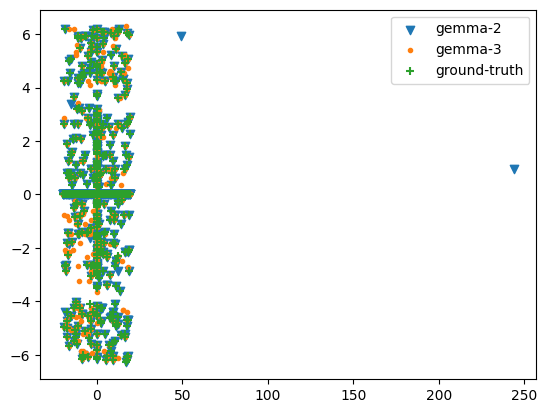

In [22]:
plt.scatter(pred_r_gemma2, pred_t_gemma2, marker="v", label="gemma-2")
plt.scatter(pred_r, pred_t, marker=".", label="gemma-3")
plt.scatter(label_r, label_t, marker="+", label="ground-truth")
plt.legend(loc='best');

In this graph, the horizontal axis is the distance to be made by the robot and the vertical axis is the orientation to be made by the robot.

The green + presents the ground-truth pose modification, the blue triangle represents the pose modification by gemma-2-2b-4bit, and the orange dot represents the pose modification by gemma-3-1b-8bit (with 10 times sampling).

In this figure, gemma-3 performs worst than gemma-2 since more orange dots are not covered by the green plus than the blue triangle.

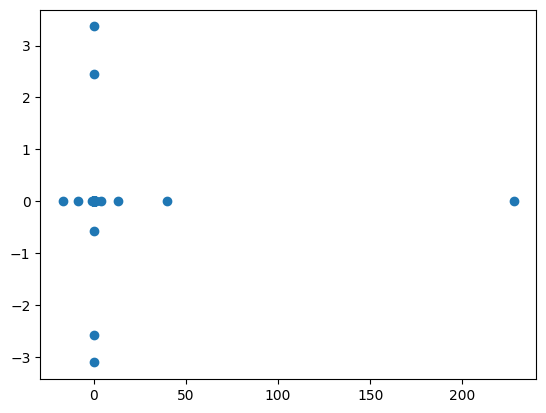

In [23]:
plt.scatter(err_r_gemma2, err_t_gemma2, label="gemma-2-2b")

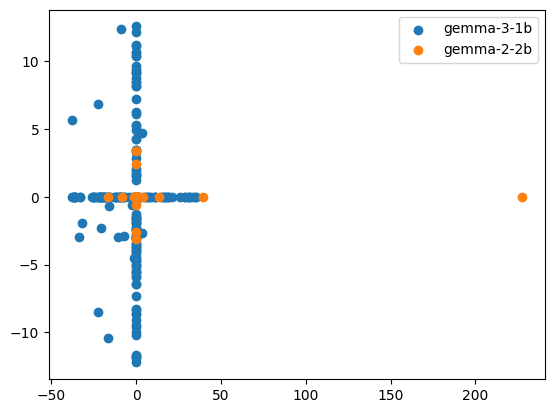

In [24]:
err_r = np.array(pred_r) - np.array(label_r)
err_t = np.array(pred_t) - np.array(label_t)
plt.scatter(err_r, err_t, label="gemma-3-1b")
plt.scatter(err_r_gemma2, err_t_gemma2, label="gemma-2-2b")
plt.legend(loc='best')

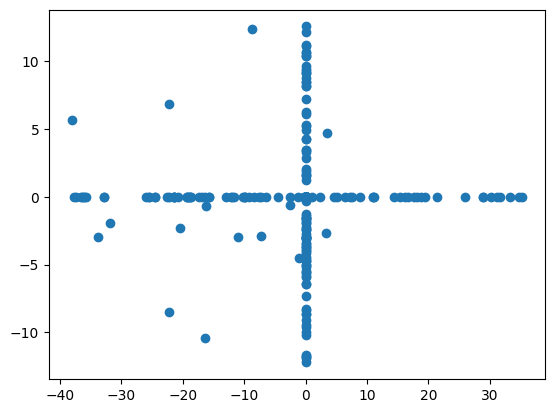

In [25]:
plt.scatter(err_r, err_t)

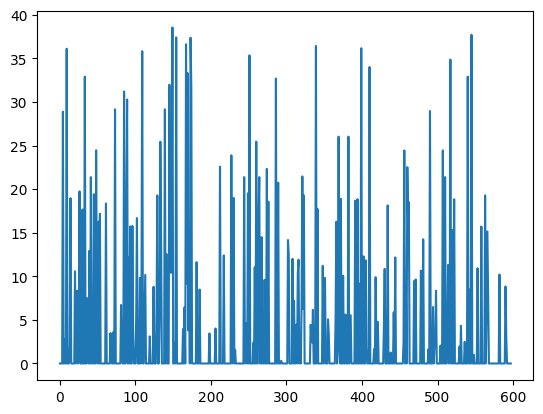

In [26]:
plt.plot(rd, label="gemma-3-1b")

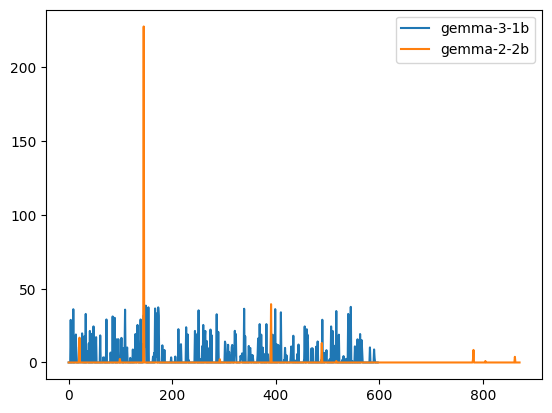

In [27]:
plt.plot(rd, label="gemma-3-1b")
plt.plot(rd_gemma2, label="gemma-2-2b")
plt.legend(loc='best')

In [28]:
np.mean(rd)

np.float64(4.21793609104979)

$4.2179$ is the pose error induced by the finetuned gemma-3 averaged over `valid.jsonl` dataset.

## Other performance metrics

In [29]:
from evaluate import load
cer = load("cer")
wer = load("wer")

Using the latest cached version of the module from /Users/cto/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--cer/9cb90b752d5f15fb41161efdbefd13570adb3f32fa157290d8a55093c47428e1 (last modified on Mon Mar 24 21:41:43 2025) since it couldn't be found locally at evaluate-metric--cer, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /Users/cto/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--wer/85bee9e4216a78bb09b2d0d500f6af5c23da58f9210e661add540f5df6630fcd (last modified on Mon Mar 24 21:42:52 2025) since it couldn't be found locally at evaluate-metric--wer, or remotely on the Hugging Face Hub.


In [30]:
cer_score = cer.compute(predictions=predictions, references=references)
print(cer_score)

0.025793322734499205


In [31]:
wer_score = wer.compute(predictions=predictions, references=references)
print(wer_score)

0.04765779379286295


In [26]:
np.save('pred_r_g3', np.array(pred_r, dtype=object), allow_pickle=True)
np.save('pred_t_g3', np.array(pred_t, dtype=object), allow_pickle=True)
np.save('rd_g3', np.array(rd, dtype=object), allow_pickle=True)

In [ ]:
model, tokenizer = load("mlx-community/gemma-2-2b-it-4bit", adapter_path="./robot-command-retrieval/adapters-gemma-2-2b-it-4bit/")